In [45]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [46]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as pyplot
import optuna as op
%matplotlib inline
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

In [47]:
dataset = pd.read_csv('../Input/interactions_and_impressions.csv')
dataset = dataset.drop(columns=['Impressions'])

datasetCOO = sp.coo_matrix((dataset["Data"].values, (dataset["UserID"].values, dataset["ItemID"].values)))
userIDS = dataset['UserID'].unique()
itemIDS = dataset['ItemID'].unique()

URM = np.zeros((len(userIDS), len(itemIDS)), dtype=int)
for x in range(len(datasetCOO.data)):
    if datasetCOO.data[x] == 0:
        URM[datasetCOO.row[x]][datasetCOO.col[x]] = int(1)

URM = sp.csr_matrix(URM)

C:\Users\Mike\AppData\Local\Temp\ipykernel_3576\4045740091.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../Input/interactions_and_impressions.csv')


In [48]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [49]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2787 ( 6.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1546 ( 3.7%) Users that have less than 1 test interactions


## Number of Neighbors

In [27]:
x_tick = [10, 25, 40, 50, 100, 500]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1103.14 column/sec. Elapsed time 22.22 sec
EvaluatorHoldout: Processed 38925 (100.0%) in 19.01 sec. Users per second: 2047
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1190.56 column/sec. Elapsed time 20.58 sec
EvaluatorHoldout: Processed 38925 (100.0%) in 19.31 sec. Users per second: 2016
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1179.81 column/sec. Elapsed time 20.77 sec
EvaluatorHoldout: Processed 38925 (100.0%) in 19.47 sec. Users per second: 2000
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting

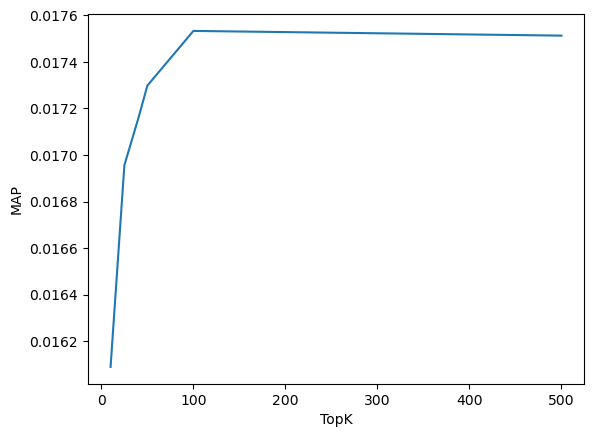

In [28]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Let's take topK=23

## Shrinkage

In [12]:
x_tick = [0, 10, 50, 100, 200]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1118.07 column/sec. Elapsed time 21.92 sec
EvaluatorHoldout: Processed 38971 (100.0%) in 21.72 sec. Users per second: 1794
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1072.05 column/sec. Elapsed time 22.86 sec
EvaluatorHoldout: Processed 38971 (100.0%) in 22.28 sec. Users per second: 1750
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1078.73 column/sec. Elapsed time 22.72 sec
EvaluatorHoldout: Processed 38971 (100.0%) in 23.66 sec. Users per second: 1647
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting

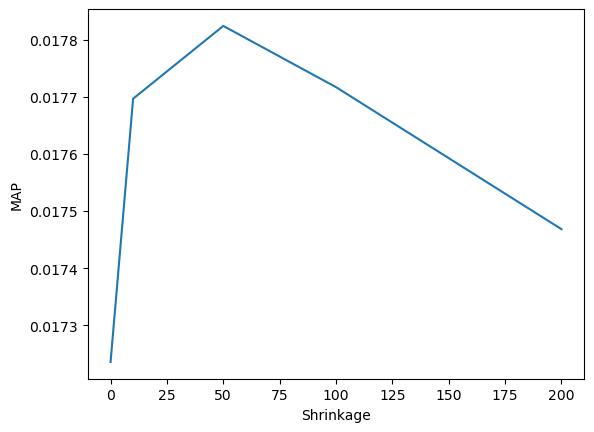

In [13]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

Let's take shrinkage = 100

## Testing of reccomenders

In [14]:
collaborative_recommender1 = ItemKNNCFRecommender(URM_train)
# collaborative_recommender1.fit(shrink=10, topK=20)

collaborative_recommender2 = ItemKNNCFRecommender(URM_train)
# collaborative_recommender2.fit(shrink=100, topK=25)

collaborative_MAP1 = []
collaborative_MAP2 = []

x_tick = []

for topK in [80, 100]:
    for shrink in [25, 50]:
        x_tick.append("topk {}, shrink {}".format(topK, shrink))

        collaborative_recommender1.fit(shrink=shrink, topK=topK)
        collaborative_recommender2.fit(shrink=shrink, topK=topK)

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender1)
        collaborative_MAP1.append(result_df.loc[10]["MAP"])

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender2)
        collaborative_MAP2.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1094.74 column/sec. Elapsed time 22.39 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1167.04 column/sec. Elapsed time 21.00 sec
EvaluatorHoldout: Processed 40081 (100.0%) in 22.85 sec. Users per second: 1754
EvaluatorHoldout: Processed 40081 (100.0%) in 22.68 sec. Users per second: 1767
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1169.16 column/sec. Elapsed time 20.96 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1146.43 column/sec. Elapsed time 21.38 sec
EvaluatorHoldout: Processed 40081 (100.0%) in 23.27 sec. Users per second: 1723
EvaluatorHoldout: Processed 40081 (100.0%) in 22.86 sec. U

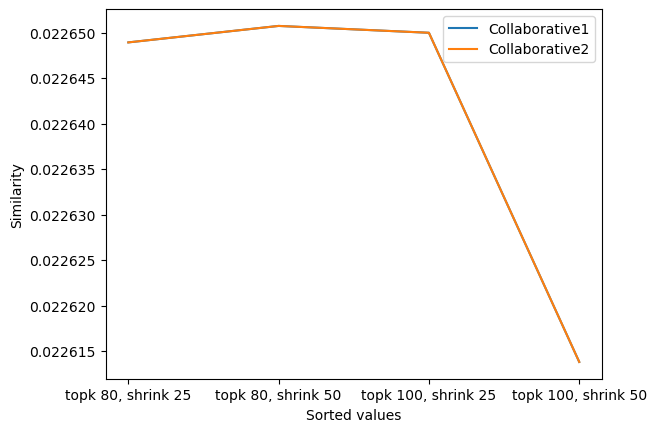

In [15]:
pyplot.plot(x_tick, collaborative_MAP1, label="Collaborative1")
pyplot.plot(x_tick, collaborative_MAP2, label="Collaborative2")

pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

## OPTUNA optimization

In [30]:
recommender = ItemKNNCFRecommender(URM_train)

def objective(trial):
    topK = trial.suggest_float("topK", 80, 90)
    shrink = trial.suggest_float("shrink", 10, 15)
    recommender.fit(topK=int(topK), shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.


In [50]:
# objective = represents the function that we need to minimize
# trial = optuna parameter that tries random values in a certain interval

def objective(trial):
    topK = trial.suggest_int("topK", 140, 160)
    shrink = trial.suggest_float("shrink", 55, 65)
    recommender.fit(topK=topK, shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

In [51]:
study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2022-11-05 09:53:11,367] A new study created in memory with name: no-name-a0f839d1-4270-4ed3-8567-201ca2d2ce81


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1029.77 column/sec. Elapsed time 23.80 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 26.07 sec. Users per second: 1490


[I 2022-11-05 09:54:01,381] Trial 0 finished with value: 0.005825077460742487 and parameters: {'topK': 147, 'shrink': 59.05487561230662}. Best is trial 0 with value: 0.005825077460742487.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1028.12 column/sec. Elapsed time 23.84 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 27.03 sec. Users per second: 1437


[I 2022-11-05 09:54:52,378] Trial 1 finished with value: 0.005849093151497798 and parameters: {'topK': 154, 'shrink': 57.47032516584955}. Best is trial 1 with value: 0.005849093151497798.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1030.04 column/sec. Elapsed time 23.79 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 27.01 sec. Users per second: 1438


[I 2022-11-05 09:55:43,318] Trial 2 finished with value: 0.005854140052945493 and parameters: {'topK': 151, 'shrink': 55.52618392019687}. Best is trial 2 with value: 0.005854140052945493.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 943.50 column/sec. Elapsed time 25.97 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 27.27 sec. Users per second: 1424


[I 2022-11-05 09:56:36,696] Trial 3 finished with value: 0.00585764121311985 and parameters: {'topK': 154, 'shrink': 61.779347330455245}. Best is trial 3 with value: 0.00585764121311985.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1094.66 column/sec. Elapsed time 22.39 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 26.06 sec. Users per second: 1490


[I 2022-11-05 09:57:25,287] Trial 4 finished with value: 0.0058281924410084965 and parameters: {'topK': 147, 'shrink': 62.48564639290929}. Best is trial 3 with value: 0.00585764121311985.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1075.62 column/sec. Elapsed time 22.78 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 25.90 sec. Users per second: 1500


[I 2022-11-05 09:58:14,084] Trial 5 finished with value: 0.005822712364213854 and parameters: {'topK': 141, 'shrink': 58.981560303020494}. Best is trial 3 with value: 0.00585764121311985.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1036.48 column/sec. Elapsed time 23.64 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 26.21 sec. Users per second: 1482


[I 2022-11-05 09:59:04,072] Trial 6 finished with value: 0.005848238038843596 and parameters: {'topK': 148, 'shrink': 63.3161951910516}. Best is trial 3 with value: 0.00585764121311985.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1058.25 column/sec. Elapsed time 23.16 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 49.61 sec. Users per second: 783


[I 2022-11-05 10:00:16,983] Trial 7 finished with value: 0.005860149339244164 and parameters: {'topK': 155, 'shrink': 60.835282444940944}. Best is trial 7 with value: 0.005860149339244164.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 550.99 column/sec. Elapsed time 44.48 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 36.74 sec. Users per second: 1057


[I 2022-11-05 10:01:38,434] Trial 8 finished with value: 0.0058555151803440075 and parameters: {'topK': 156, 'shrink': 61.970852626299326}. Best is trial 7 with value: 0.005860149339244164.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1096.49 column/sec. Elapsed time 22.35 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 26.60 sec. Users per second: 1460


[I 2022-11-05 10:02:27,505] Trial 9 finished with value: 0.005828347730283799 and parameters: {'topK': 146, 'shrink': 56.69484443756727}. Best is trial 7 with value: 0.005860149339244164.


In [52]:
topK = study.best_params['topK']
shrink = study.best_params['shrink']

In [53]:
topK

155

In [54]:
shrink

60.835282444940944

In [31]:
recommender.fit(shrink=int(11.360087017080575), topK=int(24.286589663434658))
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1145.20 column/sec. Elapsed time 21.40 sec
EvaluatorHoldout: Processed 40084 (100.0%) in 20.25 sec. Users per second: 1979


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.016638,0.028342,0.026583,0.006895,0.012005,0.059039,0.026414,0.020466,0.142002,0.063699,...,0.962886,0.136732,0.962886,0.062547,9.987618,0.996563,0.143687,0.757957,2.658988,0.521342


In [33]:
recommender.fit(shrink=25, topK=100)
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1093.94 column/sec. Elapsed time 22.40 sec
EvaluatorHoldout: Processed 40084 (100.0%) in 23.04 sec. Users per second: 1740


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.017309,0.029938,0.028193,0.007176,0.012539,0.061427,0.027627,0.021449,0.147665,0.066305,...,0.962886,0.142185,0.962886,0.047016,9.282323,0.994223,0.108007,0.704433,3.279176,0.497832


In [24]:
recommender.fit(shrink=50, topK=80)
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1045.64 column/sec. Elapsed time 23.44 sec
EvaluatorHoldout: Processed 39996 (100.0%) in 26.08 sec. Users per second: 1534


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.016932,0.029289,0.027564,0.007106,0.012572,0.061196,0.027395,0.020978,0.143764,0.06588,...,0.960773,0.138125,0.960773,0.03585,9.069113,0.994058,0.082357,0.688252,3.357806,0.4904


In [55]:
recommender_try = ItemKNNCFRecommender(URM_train)
recommender_try.fit(topK=155, shrink=60.835282444940944)


result_df, _ = evaluator_validation.evaluateRecommender(recommender_try)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1076.01 column/sec. Elapsed time 22.78 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 26.36 sec. Users per second: 1474


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.039218,0.082653,0.080303,0.017704,0.037006,0.128195,0.070728,0.052699,0.282298,0.149961,...,0.933051,0.263398,0.933051,0.031458,8.766627,0.992446,0.072189,0.665104,3.692853,0.481864


In [43]:
recommender_try = ItemKNNCFRecommender(URM_train)
recommender_try.fit(topK=150, shrink=60)


result_df, _ = evaluator_validation.evaluateRecommender(recommender_try)
result_df

ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1005.74 column/sec. Elapsed time 24.37 sec
EvaluatorHoldout: Processed 38984 (100.0%) in 27.82 sec. Users per second: 1401


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.039162,0.082337,0.080068,0.017838,0.03707,0.128873,0.070771,0.052598,0.280782,0.150903,...,0.936463,0.262942,0.936463,0.032166,8.79144,0.992498,0.073804,0.667122,3.680118,0.482355
